Link to the dataset used: https://www.ll.mit.edu/r-d/datasets/vpnnonvpn-network-application-traffic-dataset-vnat

# 32 packets

## Creating a script to process PCAP files

In [ ]:
%%writefile pcap_gobbler.sh
#!/bin/bash

if [ "$#" -ne 3 ]; then
    echo "Usage: $0 <input_directory> <output_csv_file> <python_script>"
    exit 1
fi

INPUT_DIR="$1"
OUTPUT_FILE="$2"
PYTHON_SCRIPT="$3"

SCRIPT_DIR="$(dirname "$0")"
TEMP_FILE="$SCRIPT_DIR/temp_output.csv"

if [ ! -f "$PYTHON_SCRIPT" ]; then
    echo "Python script $PYTHON_SCRIPT not found."
    exit 1
fi

if [ -f "$OUTPUT_FILE" ]; then
    rm "$OUTPUT_FILE"
fi

HEADER_WRITTEN=false

if [ ! -d "$INPUT_DIR" ]; then
    echo "Input directory $INPUT_DIR does not exist."
    exit 1
fi

for file in "$INPUT_DIR"/*.pcap; do
    if [ ! -e "$file" ]; then
        echo "No .pcap files found in $INPUT_DIR"
        exit 1
    fi

    echo "Processing $file..."

    python3.9 "$PYTHON_SCRIPT" "$file" "$TEMP_FILE"

    if [ -f "$TEMP_FILE" ]; then
        if [ "$HEADER_WRITTEN" = false ]; then
            cat "$TEMP_FILE" >> "$OUTPUT_FILE"
            HEADER_WRITTEN=true
        else
            tail -n +2 "$TEMP_FILE" >> "$OUTPUT_FILE"
        fi
    fi
done

rm -f "$TEMP_FILE"

echo "All files processed. Combined output is in $OUTPUT_FILE"

## Creating the NFStream python script

In [ ]:
%%writefile nfstream_v3.py
import sys
from nfstream import NFStreamer, NFPlugin

class FlowSlicer(NFPlugin):
    def on_init(self, packet, flow):
        if self.limit == 1:
           flow.expiration_id = -1 

    def on_update(self, packet, flow):
        if self.limit == flow.bidirectional_packets:
           flow.expiration_id = -1

if len(sys.argv) != 3:
    print("Usage: python nfstream.py <pcap_file> <output_csv>")
    sys.exit(1)

pcap_file = sys.argv[1]
output_csv = sys.argv[2]

NFStreamer(source=pcap_file,
           decode_tunnels=False,
           n_dissections=20,
           statistical_analysis=True,
           accounting_mode=1,
           n_meters=1,
           idle_timeout=120,
           active_timeout=180000,
           splt_analysis=32,
           udps=FlowSlicer(limit=32)
          ).to_csv(output_csv)

## Processing PCAP files containing non-VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing non-VPN pcap files' novpn_mit_v3.csv nfstream_v3.py

## Processing PCAP files containing VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing VPN pcap files' vpn_mit_v3.csv nfstream_v3.py

## Loading the data from the csv files

In [3]:
import pandas as pd

novpn = pd.read_csv("novpn_mit_v3.csv")
vpn = pd.read_csv("vpn_mit_v3.csv")

print(novpn.info())
print(vpn.info())

/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_9178/4155380611.py:3: DtypeWarning: Columns (83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  novpn = pd.read_csv("novpn_mit_v3.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878168 entries, 0 to 878167
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            878168 non-null  int64  
 1   expiration_id                 878168 non-null  int64  
 2   src_ip                        878168 non-null  object 
 3   src_mac                       878168 non-null  object 
 4   src_oui                       878168 non-null  object 
 5   src_port                      878168 non-null  int64  
 6   dst_ip                        878168 non-null  object 
 7   dst_mac                       878168 non-null  object 
 8   dst_oui                       878168 non-null  object 
 9   dst_port                      878168 non-null  int64  
 10  protocol                      878168 non-null  int64  
 11  ip_version                    878168 non-null  int64  
 12  vlan_id                       878168 non-nul

## Filtering out unnecessary rows from the dataset, labeling data

In [5]:
novpn['VPN'] = 'non-VPN'
vpn['VPN'] = 'VPN'

rows_to_keep = []

for i in range(1, len(vpn)):
    if vpn.loc[i - 1, 'expiration_id'] in (0, 1):
        rows_to_keep.append(i)

filtered_vpn = vpn.iloc[[0] + rows_to_keep]

print(filtered_vpn.info())

rows_to_keep = []

novpn['port_tuple'] = novpn.apply(lambda row: tuple(sorted([row['src_port'], row['dst_port']])), axis=1)

sorted_novpn = novpn.sort_values(by=['port_tuple', 'bidirectional_first_seen_ms']).reset_index(drop=True)

for i in range(1, len(sorted_novpn)):
    current_pair = sorted_novpn.loc[i, 'port_tuple']
    previous_pair = sorted_novpn.loc[i - 1, 'port_tuple']

    difference = sorted_novpn.loc[i, 'bidirectional_first_seen_ms'] - sorted_novpn.loc[i - 1, 'bidirectional_last_seen_ms']

    if current_pair != previous_pair or difference < 0 or difference >= 15000:
        rows_to_keep.append(i)

filtered_novpn = sorted_novpn.iloc[[0] + rows_to_keep].drop('port_tuple', axis=1)

print(filtered_novpn.info())

df_large = pd.concat([filtered_novpn, filtered_vpn], ignore_index=True)

print(df_large.info())

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 481801
Data columns (total 89 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            374 non-null    int64  
 1   expiration_id                 374 non-null    int64  
 2   src_ip                        374 non-null    object 
 3   src_mac                       374 non-null    object 
 4   src_oui                       374 non-null    object 
 5   src_port                      374 non-null    int64  
 6   dst_ip                        374 non-null    object 
 7   dst_mac                       374 non-null    object 
 8   dst_oui                       374 non-null    object 
 9   dst_port                      374 non-null    int64  
 10  protocol                      374 non-null    int64  
 11  ip_version                    374 non-null    int64  
 12  vlan_id                       374 non-null    int64  
 13  bidirec

## Droping unnecessary features

In [6]:
df_dropped = df_large.drop(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui',
               'src_port', 'dst_port', 'dst_ip', 'dst_mac', 'dst_oui',
               'protocol', 'ip_version', 'vlan_id', 'user_agent', 'content_type',
               'application_name', 'application_category_name',
               'application_is_guessed', 'application_confidence',
               'requested_server_name', 'client_fingerprint', 'server_fingerprint',
               'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
               'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
               'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
               'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
               'src2dst_urg_packets', 'src2dst_ack_packets', 'src2dst_psh_packets',
               'src2dst_rst_packets', 'src2dst_fin_packets', 'src2dst_syn_packets',
               'dst2src_syn_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets',
               'dst2src_urg_packets', 'dst2src_ack_packets', 'dst2src_psh_packets',
               'dst2src_rst_packets', 'dst2src_fin_packets', 'dst2src_syn_packets',
               'bidirectional_syn_packets', 'bidirectional_cwr_packets', 'bidirectional_ece_packets',
               'bidirectional_urg_packets', 'bidirectional_ack_packets', 'bidirectional_psh_packets',
               'bidirectional_rst_packets', 'bidirectional_fin_packets', 'bidirectional_syn_packets',
               'splt_direction', 'splt_ps', 'splt_piat_ms'], axis=1)

print(df_dropped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176087 entries, 0 to 176086
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bidirectional_duration_ms     176087 non-null  int64  
 1   bidirectional_packets         176087 non-null  int64  
 2   bidirectional_bytes           176087 non-null  int64  
 3   src2dst_duration_ms           176087 non-null  int64  
 4   src2dst_packets               176087 non-null  int64  
 5   src2dst_bytes                 176087 non-null  int64  
 6   dst2src_duration_ms           176087 non-null  int64  
 7   dst2src_packets               176087 non-null  int64  
 8   dst2src_bytes                 176087 non-null  int64  
 9   bidirectional_min_ps          176087 non-null  int64  
 10  bidirectional_mean_ps         176087 non-null  float64
 11  bidirectional_stddev_ps       176087 non-null  float64
 12  bidirectional_max_ps          176087 non-nul

## Displaying feature importance using ExtraTreesClassifier

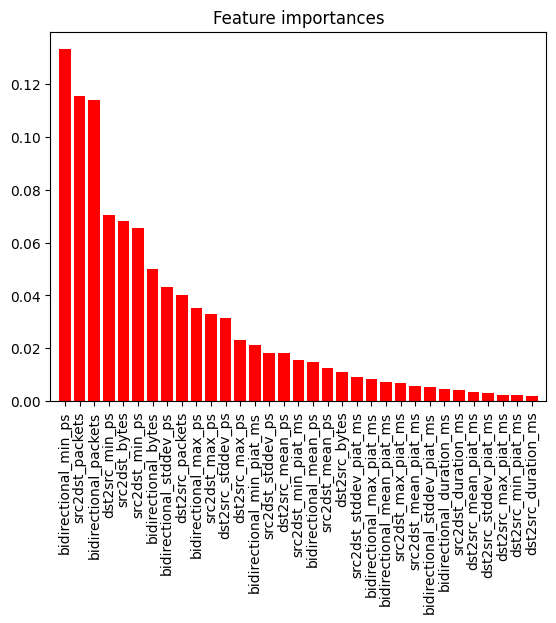

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

label_encoder = LabelEncoder()

df_using = df_dropped.copy(deep=True)
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

extra = ExtraTreesClassifier(random_state=420)

extra.fit(scaled_X, y)

importances = extra.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Decision Tree

Train Accuracy: 0.9999929012060851
Validation Accuracy: 0.999971605429042
              precision    recall  f1-score   support

         VPN       0.99      1.00      0.99        75
     non-VPN       1.00      1.00      1.00     35143

    accuracy                           1.00     35218
   macro avg       0.99      1.00      1.00     35218
weighted avg       1.00      1.00      1.00     35218



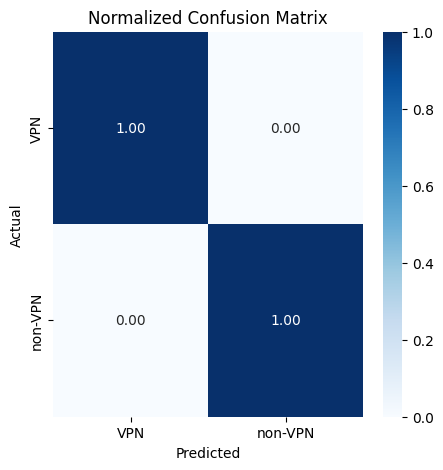

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_using = df_dropped.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Visualizing the Decision Tree

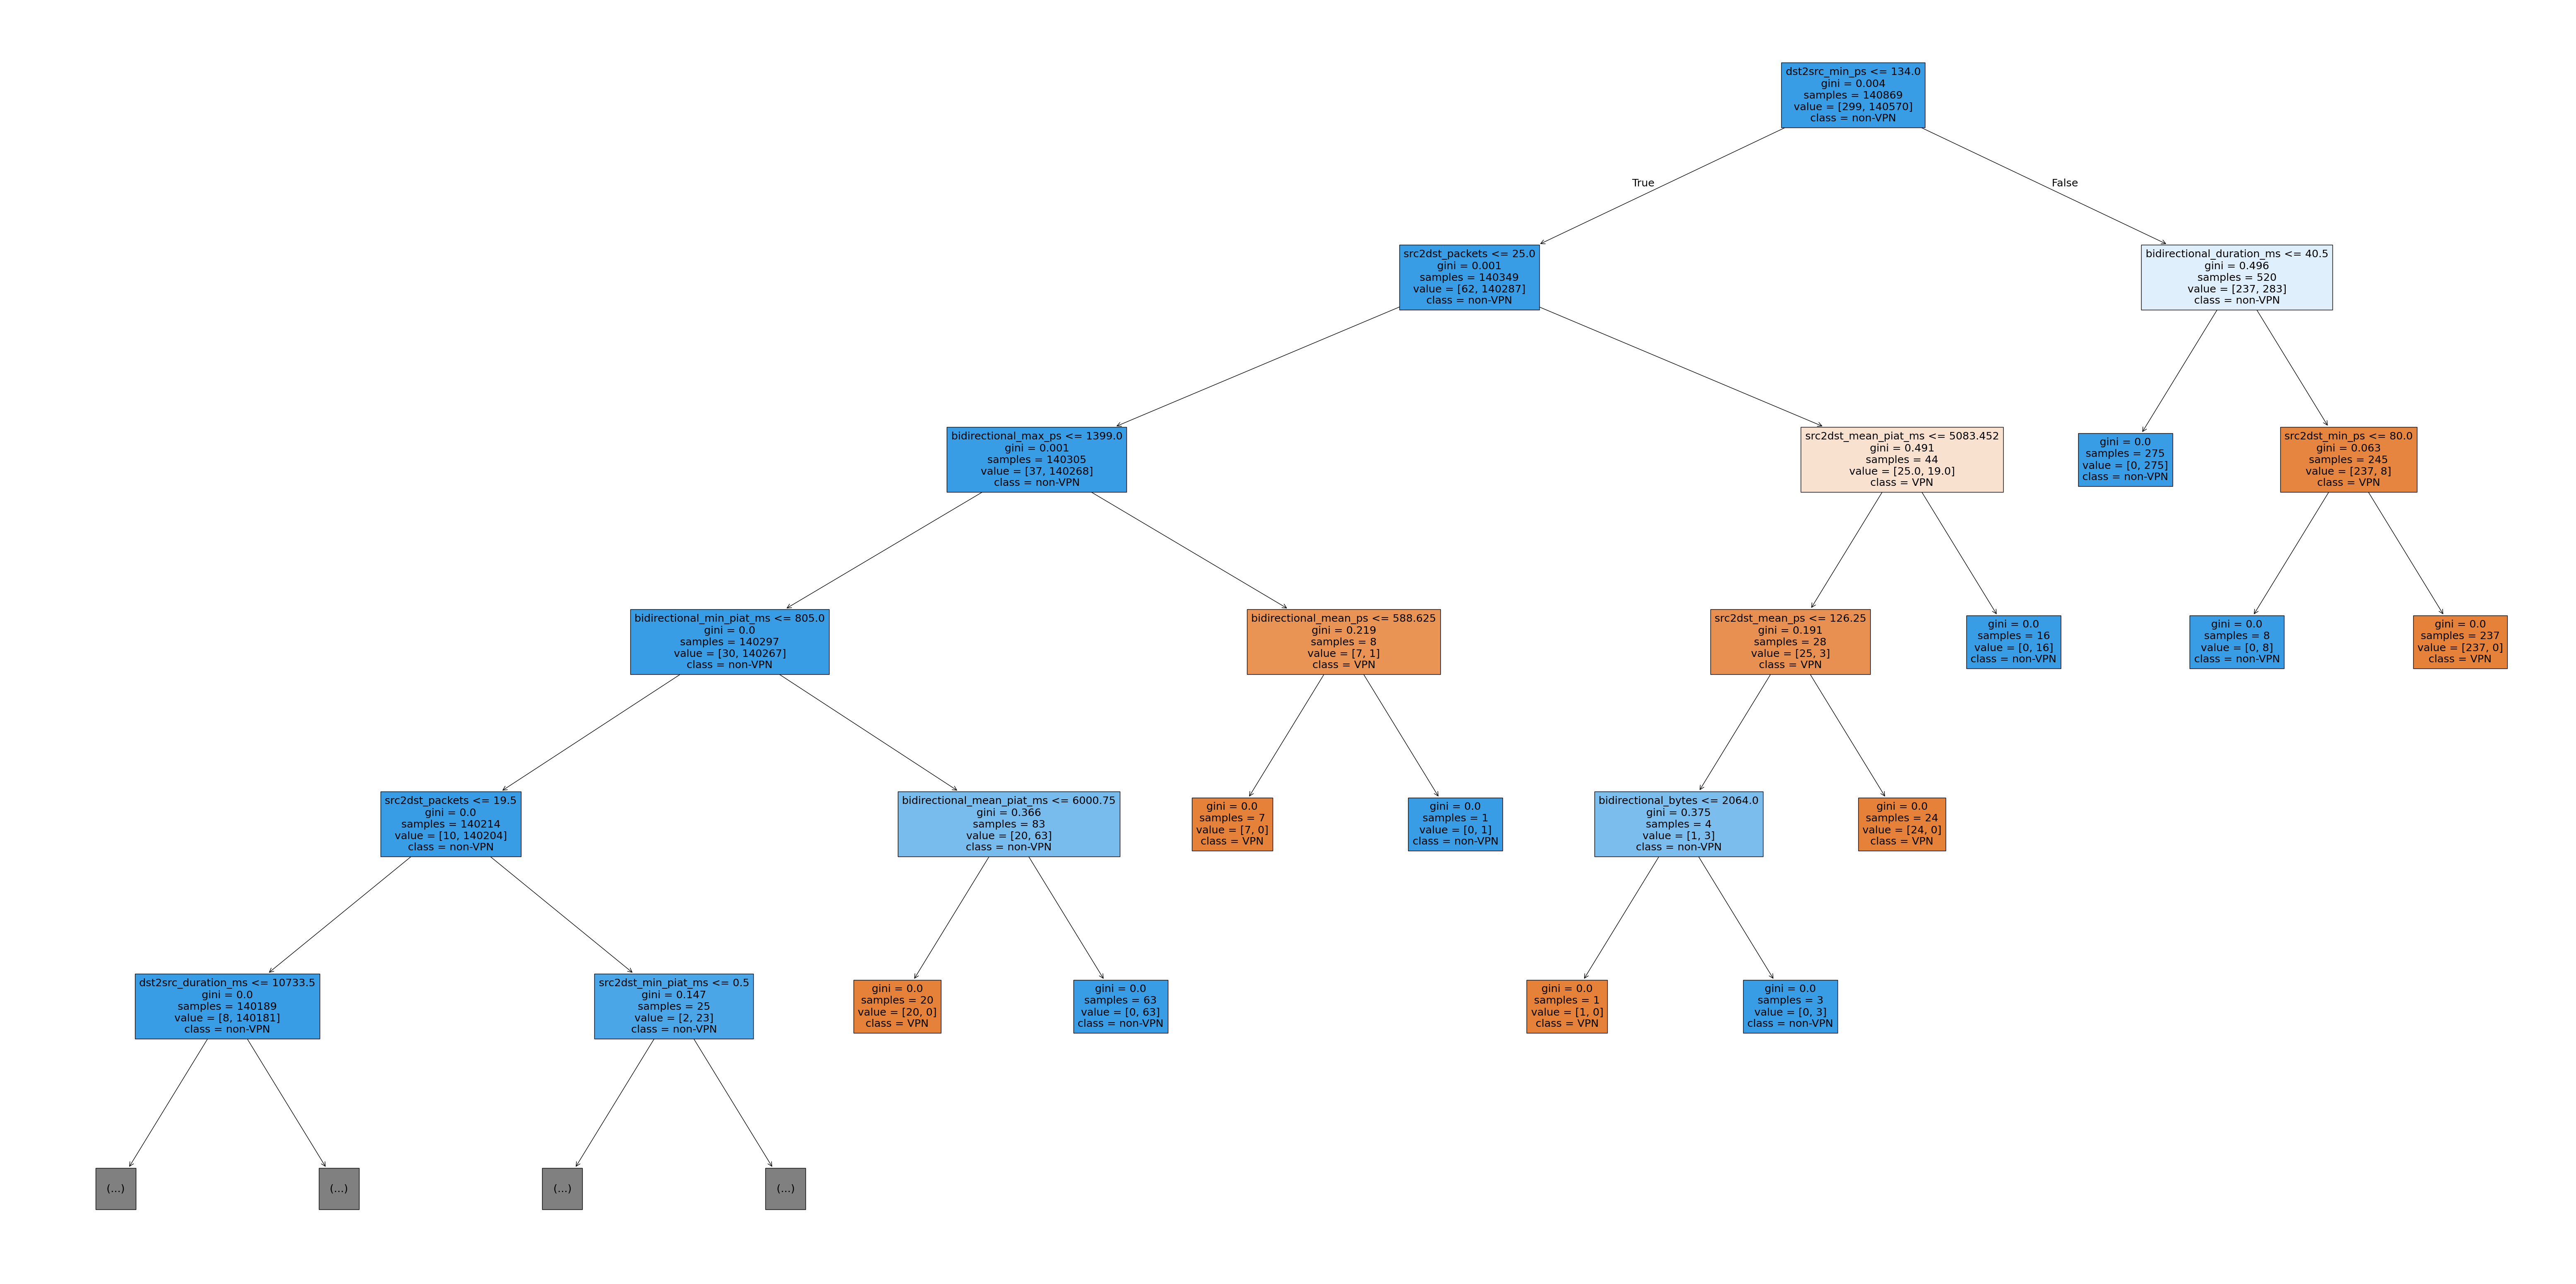

In [9]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 40))
plot_tree(clf, max_depth=5, filled=True, feature_names=X.columns, class_names=[str(i) for i in le.classes_])
plt.show()

## Random Forest

Train Accuracy: 0.9999929012060851
Validation Accuracy: 0.999971605429042
              precision    recall  f1-score   support

         VPN       1.00      0.99      0.99        75
     non-VPN       1.00      1.00      1.00     35143

    accuracy                           1.00     35218
   macro avg       1.00      0.99      1.00     35218
weighted avg       1.00      1.00      1.00     35218



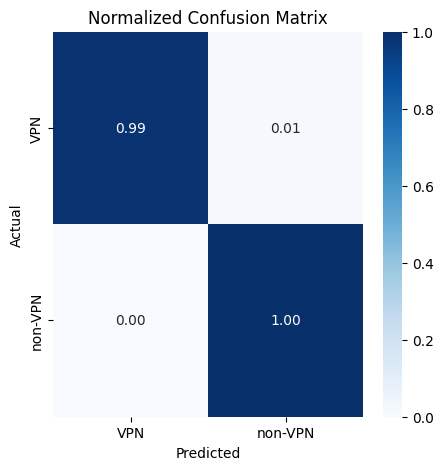

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_using = df_dropped.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Neural Network

2024-11-26 01:30:00.558636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4403/4403 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9984 - loss: 0.0304 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 2/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 3/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 6.5498e-04 - val_accuracy: 0.9998 - val_loss: 8.9820e-04
Epoch 4/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9999 - loss: 3.1083e-04 - val_accuracy: 0.9998 - val_loss: 5.1296e-04
Epoch 5/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9999 - loss: 3.0553e-04 - val_accuracy: 0.9998 - val_loss: 6.9777e-04
Epoch 6/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9999 - loss: 3.3510e-04 - val_accuracy: 1.0000 - val_loss: 1.9633e-04
Epoch 7/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9999 - loss: 2.2980e-04 - val_accuracy: 1.0000 - val_loss: 6.8847e-05
Epoch 8/20
4403/4403 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step 

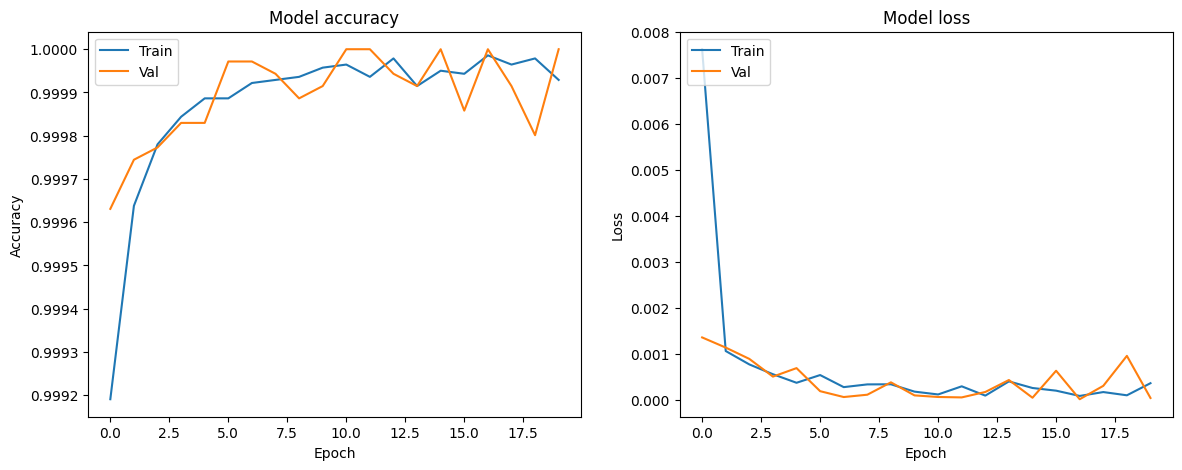

Train Accuracy: 0.9999290108680725
Validation Accuracy: 1.0
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         VPN       1.00      1.00      1.00        75
     non-VPN       1.00      1.00      1.00     35143

    accuracy                           1.00     35218
   macro avg       1.00      1.00      1.00     35218
weighted avg       1.00      1.00      1.00     35218



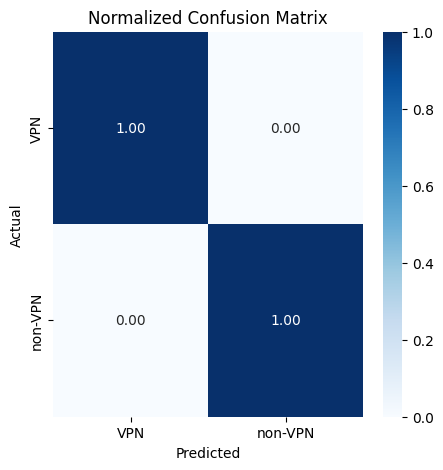

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_using = df_dropped.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with one neuron per class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Concatenating and writing out macro average data

In [12]:
from IPython.display import display

macro_avg_data = dt_report['macro avg']

df_macro_avg = pd.DataFrame.from_dict(macro_avg_data, orient='index').transpose()

df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report['macro avg'], index=[0])], ignore_index=True)

accuracy_column = [dt_report['accuracy'], rf_report['accuracy'], nn_report['accuracy']]
df_accuracy = pd.DataFrame({'accuracy': accuracy_column})
df_macro_avg = pd.concat([df_accuracy, df_macro_avg], axis=1)

model_column = ['Decision Tree', 'Random Forest', 'Neural Network']
df_model = pd.DataFrame({'model': model_column})
df_macro_avg = pd.concat([df_model, df_macro_avg], axis=1)

df_macro_avg = df_macro_avg.drop(columns='support', axis=1)

display(df_macro_avg)

,model,accuracy,precision,recall,f1-score
0,Decision Tree,0.999972,0.993421,0.999986,0.996682
1,Random Forest,0.999972,0.999986,0.993333,0.996637
2,Neural Network,1.000000,1.000000,1.000000,1.000000


# 40 packets

## Creating the NFStream python script

In [ ]:
%%writefile nfstream_v4.py
import sys
from nfstream import NFStreamer, NFPlugin

class FlowSlicer(NFPlugin):
    def on_init(self, packet, flow):
        if self.limit == 1:
           flow.expiration_id = -1 

    def on_update(self, packet, flow):
        if self.limit == flow.bidirectional_packets:
           flow.expiration_id = -1

if len(sys.argv) != 3:
    print("Usage: python nfstream.py <pcap_file> <output_csv>")
    sys.exit(1)

pcap_file = sys.argv[1]
output_csv = sys.argv[2]

NFStreamer(source=pcap_file,
           decode_tunnels=False,
           n_dissections=20,
           statistical_analysis=True,
           accounting_mode=1,
           n_meters=1,
           idle_timeout=120,
           active_timeout=180000,
           splt_analysis=40,
           udps=FlowSlicer(limit=40)
          ).to_csv(output_csv)

## Processing PCAP files containing non-VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing non-VPN pcap files' novpn_mit_v4.csv nfstream_v4.py

## Processing PCAP files containing VPN traffic

In [ ]:
!bash pcap_gobbler.sh 'path to the directory containing VPN pcap files' vpn_mit_v4.csv nfstream_v4.py

## Loading the data from the csv files

In [6]:
import pandas as pd

novpn = pd.read_csv("novpn_mit_v4.csv")
vpn = pd.read_csv("vpn_mit_v4.csv")

print(novpn.info())
print(vpn.info())

/var/folders/k8/gygzhdfx1sg9tj1yhmpjxtnw0000gn/T/ipykernel_93685/622425890.py:3: DtypeWarning: Columns (83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  novpn = pd.read_csv("novpn_mit_v4.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737380 entries, 0 to 737379
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            737380 non-null  int64  
 1   expiration_id                 737380 non-null  int64  
 2   src_ip                        737380 non-null  object 
 3   src_mac                       737380 non-null  object 
 4   src_oui                       737380 non-null  object 
 5   src_port                      737380 non-null  int64  
 6   dst_ip                        737380 non-null  object 
 7   dst_mac                       737380 non-null  object 
 8   dst_oui                       737380 non-null  object 
 9   dst_port                      737380 non-null  int64  
 10  protocol                      737380 non-null  int64  
 11  ip_version                    737380 non-null  int64  
 12  vlan_id                       737380 non-nul

## Filtering out unnecessary rows from the dataset, labeling data

In [7]:
novpn['VPN'] = 'non-VPN'
vpn['VPN'] = 'VPN'

rows_to_keep = []

for i in range(1, len(vpn)):
    if vpn.loc[i - 1, 'expiration_id'] in (0, 1):
        rows_to_keep.append(i)

filtered_vpn = vpn.iloc[[0] + rows_to_keep]

print(filtered_vpn.info())

rows_to_keep = []

novpn['port_tuple'] = novpn.apply(lambda row: tuple(sorted([row['src_port'], row['dst_port']])), axis=1)

sorted_novpn = novpn.sort_values(by=['port_tuple', 'bidirectional_first_seen_ms']).reset_index(drop=True)

for i in range(1, len(sorted_novpn)):
    current_pair = sorted_novpn.loc[i, 'port_tuple']
    previous_pair = sorted_novpn.loc[i - 1, 'port_tuple']

    difference = sorted_novpn.loc[i, 'bidirectional_first_seen_ms'] - sorted_novpn.loc[i - 1, 'bidirectional_last_seen_ms']

    if current_pair != previous_pair or difference < 0 or difference >= 15000:
        rows_to_keep.append(i)

filtered_novpn = sorted_novpn.iloc[[0] + rows_to_keep].drop('port_tuple', axis=1)

print(filtered_novpn.info())

df_large = pd.concat([filtered_novpn, filtered_vpn], ignore_index=True)

print(df_large.info())

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 385516
Data columns (total 89 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            379 non-null    int64  
 1   expiration_id                 379 non-null    int64  
 2   src_ip                        379 non-null    object 
 3   src_mac                       379 non-null    object 
 4   src_oui                       379 non-null    object 
 5   src_port                      379 non-null    int64  
 6   dst_ip                        379 non-null    object 
 7   dst_mac                       379 non-null    object 
 8   dst_oui                       379 non-null    object 
 9   dst_port                      379 non-null    int64  
 10  protocol                      379 non-null    int64  
 11  ip_version                    379 non-null    int64  
 12  vlan_id                       379 non-null    int64  
 13  bidirec

## Droping unnecessary features

In [8]:
df_dropped = df_large.drop(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui',
               'src_port', 'dst_port', 'dst_ip', 'dst_mac', 'dst_oui',
               'protocol', 'ip_version', 'vlan_id', 'user_agent', 'content_type',
               'application_name', 'application_category_name',
               'application_is_guessed', 'application_confidence',
               'requested_server_name', 'client_fingerprint', 'server_fingerprint',
               'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
               'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
               'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
               'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
               'src2dst_urg_packets', 'src2dst_ack_packets', 'src2dst_psh_packets',
               'src2dst_rst_packets', 'src2dst_fin_packets', 'src2dst_syn_packets',
               'dst2src_syn_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets',
               'dst2src_urg_packets', 'dst2src_ack_packets', 'dst2src_psh_packets',
               'dst2src_rst_packets', 'dst2src_fin_packets', 'dst2src_syn_packets',
               'bidirectional_syn_packets', 'bidirectional_cwr_packets', 'bidirectional_ece_packets',
               'bidirectional_urg_packets', 'bidirectional_ack_packets', 'bidirectional_psh_packets',
               'bidirectional_rst_packets', 'bidirectional_fin_packets', 'bidirectional_syn_packets',
               'splt_direction', 'splt_ps', 'splt_piat_ms'], axis=1)

print(df_dropped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176043 entries, 0 to 176042
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bidirectional_duration_ms     176043 non-null  int64  
 1   bidirectional_packets         176043 non-null  int64  
 2   bidirectional_bytes           176043 non-null  int64  
 3   src2dst_duration_ms           176043 non-null  int64  
 4   src2dst_packets               176043 non-null  int64  
 5   src2dst_bytes                 176043 non-null  int64  
 6   dst2src_duration_ms           176043 non-null  int64  
 7   dst2src_packets               176043 non-null  int64  
 8   dst2src_bytes                 176043 non-null  int64  
 9   bidirectional_min_ps          176043 non-null  int64  
 10  bidirectional_mean_ps         176043 non-null  float64
 11  bidirectional_stddev_ps       176043 non-null  float64
 12  bidirectional_max_ps          176043 non-nul

## Displaying feature importance using ExtraTreesClassifier

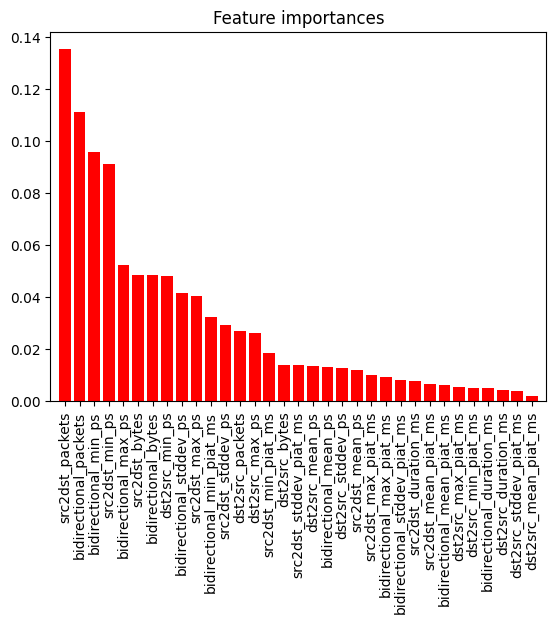

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

label_encoder = LabelEncoder()

df_using = df_dropped.copy(deep=True)
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

extra = ExtraTreesClassifier(random_state=420)

extra.fit(scaled_X, y)

importances = extra.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Decision Tree

Train Accuracy: 0.9999928994418962
Validation Accuracy: 0.9999431963418444
              precision    recall  f1-score   support

         VPN       0.99      0.99      0.99        76
     non-VPN       1.00      1.00      1.00     35133

    accuracy                           1.00     35209
   macro avg       0.99      0.99      0.99     35209
weighted avg       1.00      1.00      1.00     35209



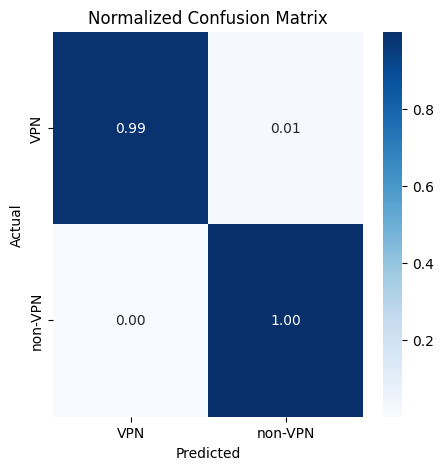

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_using = df_dropped.copy(deep=True)
le = LabelEncoder()
df_using['label_encoded'] = le.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

clf = DecisionTreeClassifier(random_state=69)

clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
val_predictions = clf.predict(X_val)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

dt_report = classification_report(y_val, val_predictions, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=le.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Visualizing the Decision Tree

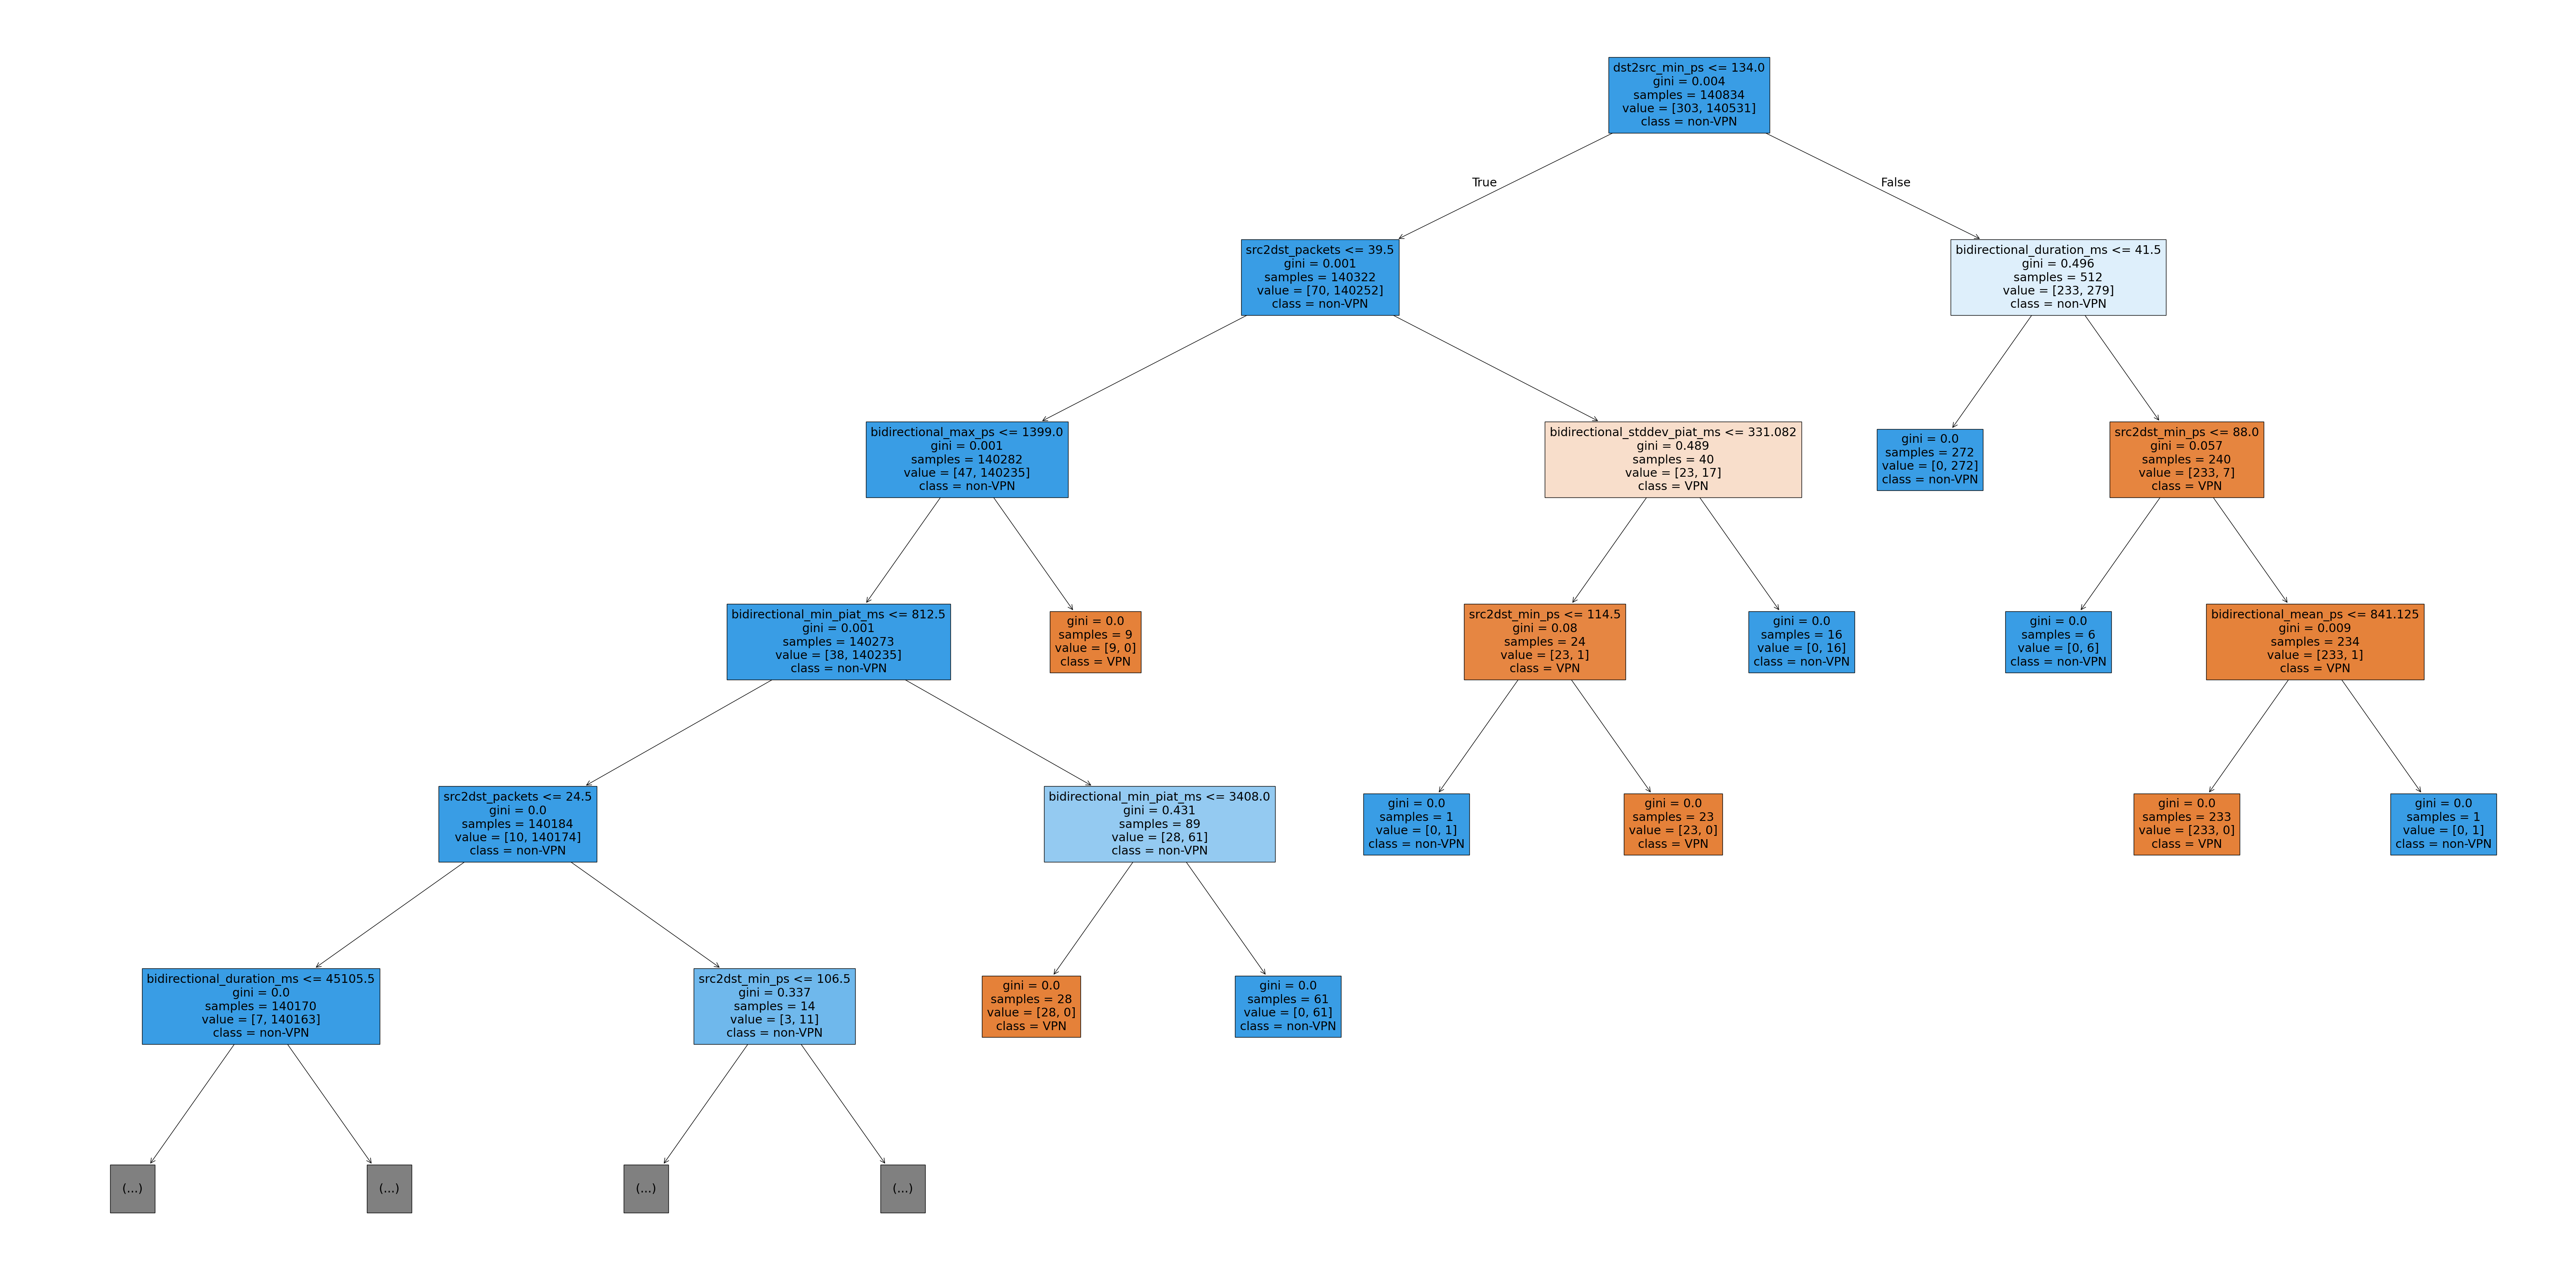

In [22]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 40))
plot_tree(clf, max_depth=5, filled=True, feature_names=X.columns, class_names=[str(i) for i in le.classes_])
plt.show()

## Random Forest

Train Accuracy: 0.9999928994418962
Validation Accuracy: 1.0
              precision    recall  f1-score   support

         VPN       1.00      1.00      1.00        76
     non-VPN       1.00      1.00      1.00     35133

    accuracy                           1.00     35209
   macro avg       1.00      1.00      1.00     35209
weighted avg       1.00      1.00      1.00     35209



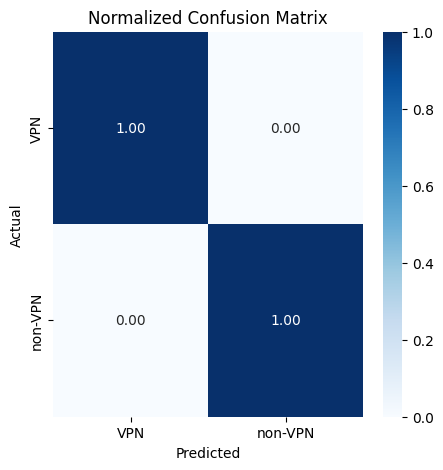

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_using = df_dropped.copy(deep=True)
label_encoder = LabelEncoder()
df_using['label_encoded'] = label_encoder.fit_transform(df_using['VPN'])

X = df_using.drop(['VPN', 'label_encoded'], axis=1)
y = df_using['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

rf_clf = RandomForestClassifier(random_state=69)

rf_clf.fit(X_train, y_train)

train_predictions = rf_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f'Train Accuracy: {train_accuracy}')

val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

rf_report = classification_report(y_val, val_predictions, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, val_predictions, normalize='true')

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Neural Network

2024-12-08 18:04:45.373655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zombi170/Documents/python/notebook_venv9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9987 - loss: 0.0291 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 2/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 9.8877e-04
Epoch 3/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 6.0444e-04 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 4/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 4.6329e-04 - val_accuracy: 0.9999 - val_loss: 5.2605e-04
Epoch 5/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 3.4002e-04 - val_accuracy: 0.9999 - val_loss: 4.2882e-04
Epoch 6/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 1.0000 - loss: 9.3943e-05 - val_accuracy: 0.9998 - val_loss: 8.1174e-04
Epoch 7/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9999 - loss: 1.9490e-04 - val_accuracy: 0.9999 - val_loss: 5.4573e-04
Epoch 8/20
4402/4402 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms

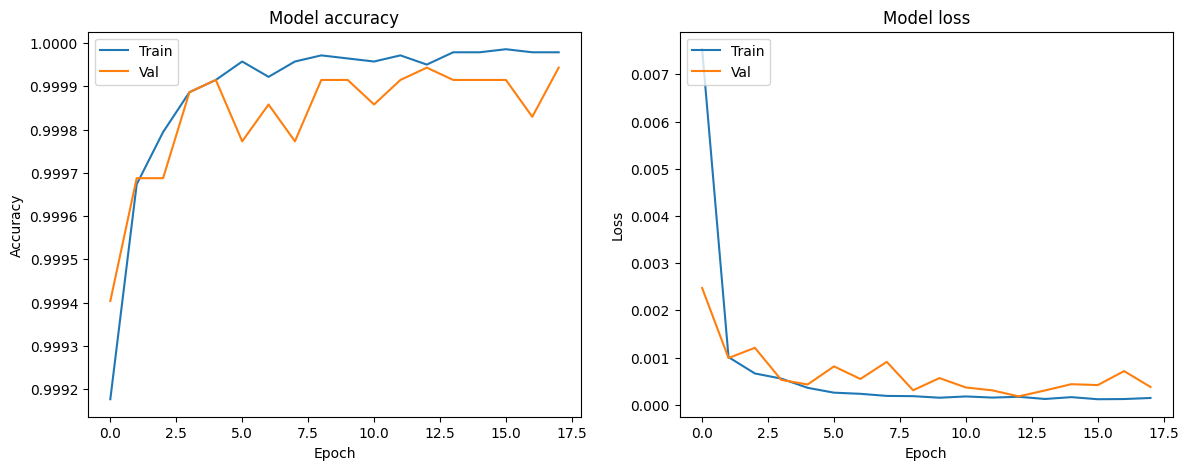

Train Accuracy: 0.9999787211418152
Validation Accuracy: 0.999943196773529
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

         VPN       1.00      0.97      0.99        76
     non-VPN       1.00      1.00      1.00     35133

    accuracy                           1.00     35209
   macro avg       1.00      0.99      0.99     35209
weighted avg       1.00      1.00      1.00     35209



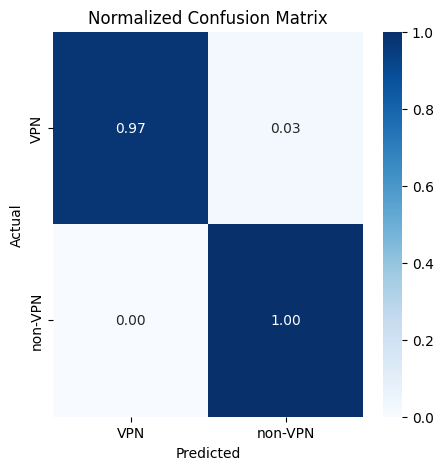

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_using = df_dropped.copy(deep=True)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(df_using[['VPN']])

X = df_using.drop(['VPN'], axis=1)
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

model = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with one neuron per class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(scaled_X_train, y_train, epochs=20, validation_data=(scaled_X_val, y_val), callbacks=[early_stopping])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

train_accuracy = history.history['accuracy'][len(history.history['accuracy']) - 1]
print(f'Train Accuracy: {train_accuracy}')

val_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy']) - 1]
print(f'Validation Accuracy: {val_accuracy}')

y_pred = model.predict(scaled_X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

nn_report = classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0], output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

## Concatenating and writing out macro average data

In [12]:
from IPython.display import display

macro_avg_data = dt_report['macro avg']

df_macro_avg = pd.DataFrame.from_dict(macro_avg_data, orient='index').transpose()

df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(rf_report['macro avg'], index=[0])], ignore_index=True)
df_macro_avg = pd.concat([df_macro_avg, pd.DataFrame(nn_report['macro avg'], index=[0])], ignore_index=True)

accuracy_column = [dt_report['accuracy'], rf_report['accuracy'], nn_report['accuracy']]
df_accuracy = pd.DataFrame({'accuracy': accuracy_column})
df_macro_avg = pd.concat([df_accuracy, df_macro_avg], axis=1)

model_column = ['Decision Tree', 'Random Forest', 'Neural Network']
df_model = pd.DataFrame({'model': model_column})
df_macro_avg = pd.concat([df_model, df_macro_avg], axis=1)

df_macro_avg = df_macro_avg.drop(columns='support', axis=1)

display(df_macro_avg)

,model,accuracy,precision,recall,f1-score
0,Decision Tree,0.999943,0.993407,0.993407,0.993407
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,Neural Network,0.999943,0.999972,0.986842,0.993319
